<a href="https://colab.research.google.com/github/Resia05/portfolio/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK

In this project, I will be engaged in time series modeling based on data from the Store Item Demand Forecasting Challenge. My goal is to find the most effective model by experimenting with the functionalities of the darts library and focusing on analyzing the training data. [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview).

**Task**

I have data on product sales in stores over a five-year period. My objective is to learn how to forecast sales for the next month for each of the 50 products in 10 stores, conducting experiments to determine the best model. Unlike the original competition, I will use the MAPE (Mean Absolute Percentage Error) metric.

# Connection to Kaggle

In [ ]:
# Install the Kaggle library.
!pip install kaggle

# Import files module from Google Colab to upload the Kaggle API key.
from google.colab import files

# Upload the kaggle.json file, which contains the API credentials.
files.upload()

# List files in the current directory to verify the upload.
!ls

# Create a directory for Kaggle configuration if it doesn't exist.
!mkdir -p /root/.kaggle

# Move the uploaded kaggle.json file to the Kaggle configuration directory.
!mv kaggle.json /root/.kaggle/

# Set permissions for the kaggle.json file to ensure it's secure.
!chmod 600 /root/.kaggle/kaggle.json

# Download the training data for the competition.
!kaggle competitions download -c demand-forecasting-kernels-only -f train.csv

# Unzip the downloaded CSV file into a specified directory.
!unzip /content/train.csv.zip -d /content/data

# List available datasets in Kaggle.
!kaggle datasets list


# Data Loading


Load the data into Pandas.

- Download the data from the train.csv.zip file using the Pandas library.
- Convert the date column to datetime format.
- Set the date column as the index for the DataFrame.
- Display the first 10 rows of the resulting DataFrame and its information.

In [ ]:
# imports
# !pip install darts --quiet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape
from darts.models import ExponentialSmoothing, AutoARIMA, Theta
from darts.models import NaiveSeasonal, NaiveDrift
from darts.models import Prophet
from darts.models import RNNModel
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima
import numpy as np

In [ ]:
# Data loading
df = pd.read_csv('/content/data/train.csv')

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df.set_index('date', inplace=True)

# Add a month column (not in the task)
df['month'] = df.index.month

# DataFrame information
df.info()

# View the first 10 rows
df.head(10)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
 3   month   913000 non-null  int32
dtypes: int32(1), int64(3)
memory usage: 31.3 MB


store  item  sales  month
date                                 
2013-01-01      1     1     13      1
2013-01-02      1     1     11      1
2013-01-03      1     1     14      1
2013-01-04      1     1     13      1
2013-01-05      1     1     10      1
2013-01-06      1     1     12      1
2013-01-07      1     1     10      1
2013-01-08      1     1      9      1
2013-01-09      1     1     12      1
2013-01-10      1     1      9      1

In [ ]:
# Basic statistics
df.describe()

store           item          sales          month
count  913000.000000  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287       6.523549
std         2.872283      14.430878      28.801144       3.448535
min         1.000000       1.000000       0.000000       1.000000
25%         3.000000      13.000000      30.000000       4.000000
50%         5.500000      25.500000      47.000000       7.000000
75%         8.000000      38.000000      70.000000      10.000000
max        10.000000      50.000000     231.000000      12.000000

# Visualization of dynamics

Now I want to gain a better understanding of the data. I have 10 stores and 50 items in each. My goal is to determine whether the sales dynamics differ for each item across different stores. I will consider how to visualize this and create three graphs to help with the analysis. I can use any tool, such as matplotlib, seaborn, or plotly.



In [ ]:
def plot_item_sales(df, item_id):
    """
    Plot the average sales for a specific item.

    Parameters:
    df (pd.DataFrame): DataFrame containing sales data.
    item_id (int): Identifier for the item to plot.
    """
    # Select the item
    item_sales = df[df['item'] == item_id]

    # Calculate average daily sales
    daily_avg_sales = item_sales.groupby(item_sales.index).agg({'sales': 'mean'})

    # Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(daily_avg_sales.index, daily_avg_sales['sales'], label=f'Item {item_id}')
    plt.title(f'Average Sales Over Time for Item {item_id}')
    plt.xlabel('Date')
    plt.ylabel('Average Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

Enter item_id: 1


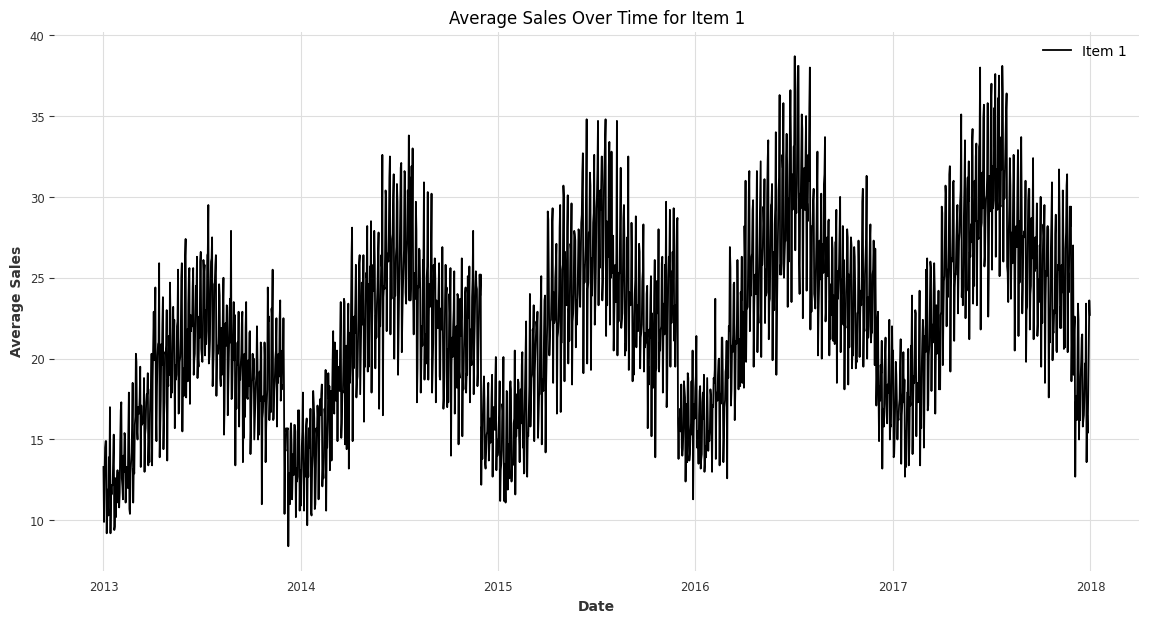

In [ ]:
# Using the function
item_id = int(input("Enter item_id: "))
plot_item_sales(df, item_id)

Enter item_id: 3


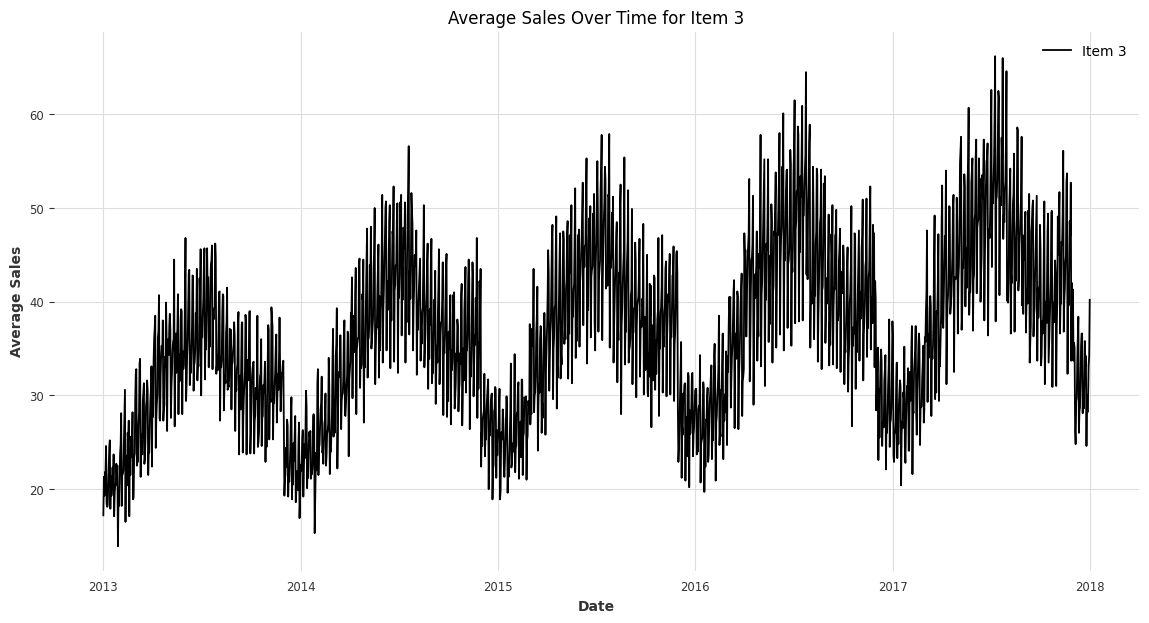

In [ ]:
# Using the function
item_id = int(input("Enter item_id: "))
plot_item_sales(df, item_id)

In [ ]:
def plot_multiple_items_sales(df, items_to_plot):
    """
    Plot average sales with confidence intervals for multiple items.

    Parameters:
    df (pd.DataFrame): DataFrame containing sales data.
    items_to_plot (list): List of item identifiers to plot.
    """
    # Select multiple items
    item_sales = df[df['item'].isin(items_to_plot)]

    # Prepare data
    item_sales_grouped = item_sales.groupby(['item', item_sales.index]).agg({'sales': ['mean', 'std']})
    item_sales_grouped.columns = ['mean_sales', 'std_sales']
    item_sales_grouped.reset_index(inplace=True)

    # Visualization
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=item_sales_grouped, x='date', y='mean_sales', hue='item', errorbar='sd', palette='tab10')
    plt.title('Average Sales with Confidence Intervals for Selected Items')
    plt.xlabel('Date')
    plt.ylabel('Average Sales')
    plt.grid(True)
    plt.show()

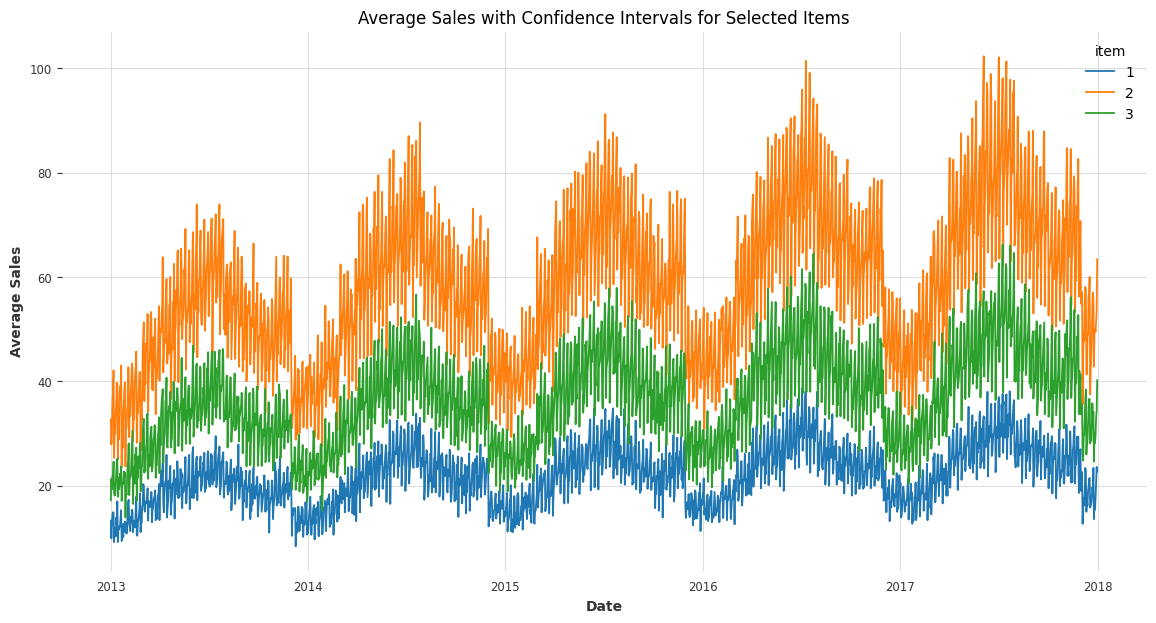

In [ ]:
# Using the function
items_to_plot = [1, 2, 3]
plot_multiple_items_sales(df, items_to_plot)

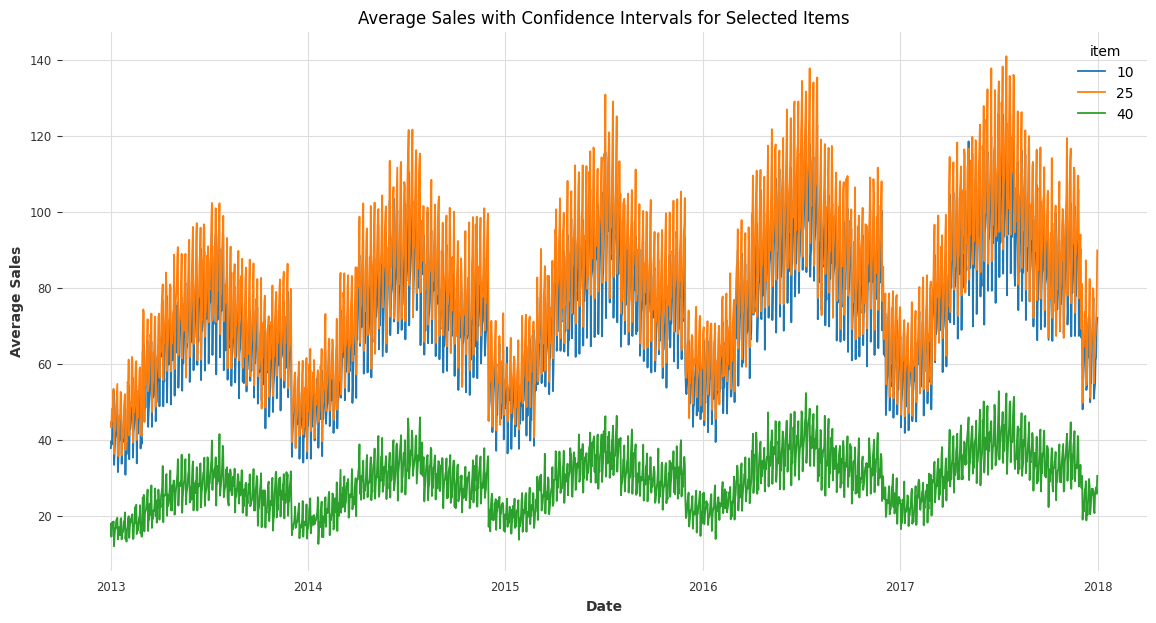

In [ ]:
# Using the function
items_to_plot = [10, 25, 40]
plot_multiple_items_sales(df, items_to_plot)

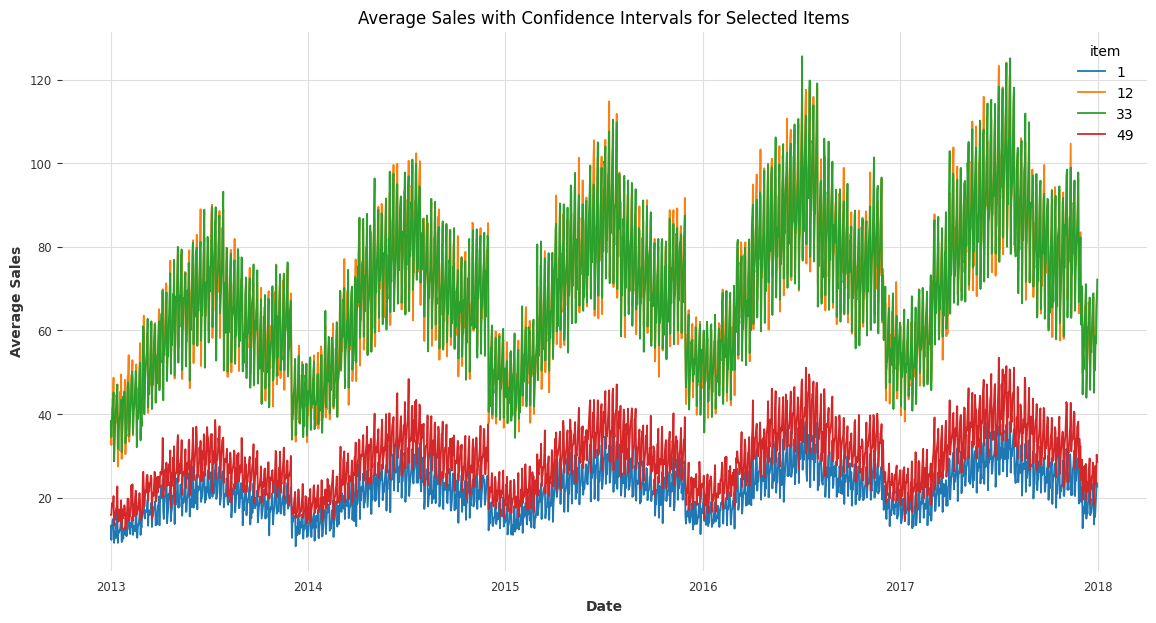

In [ ]:
# Using the function
items_to_plot = [1, 12, 33, 49]
plot_multiple_items_sales(df, items_to_plot)

In [ ]:
def plot_item_sales_across_stores(df, stores_to_plot, items_to_plot):
    """
    Plot average sales for multiple items across multiple stores without confidence intervals.

    Parameters:
    df (pd.DataFrame): DataFrame containing sales data.
    stores_to_plot (list): List of store identifiers to plot.
    items_to_plot (list): List of item identifiers to plot.
    """
    # Select multiple items and stores
    item_store_sales = df[df['store'].isin(stores_to_plot) & df['item'].isin(items_to_plot)]

    # Prepare data
    item_store_sales_grouped = item_store_sales.groupby(['store', 'item', item_store_sales.index]).agg({'sales': 'mean'})
    item_store_sales_grouped.reset_index(inplace=True)

    # Visualization
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=item_store_sales_grouped, x='date', y='sales', hue='item', style='store', palette='tab10')
    plt.title('Average Sales Over Time for Items Across Stores')
    plt.xlabel('Date')
    plt.ylabel('Average Sales')
    plt.grid(True)
    plt.show()

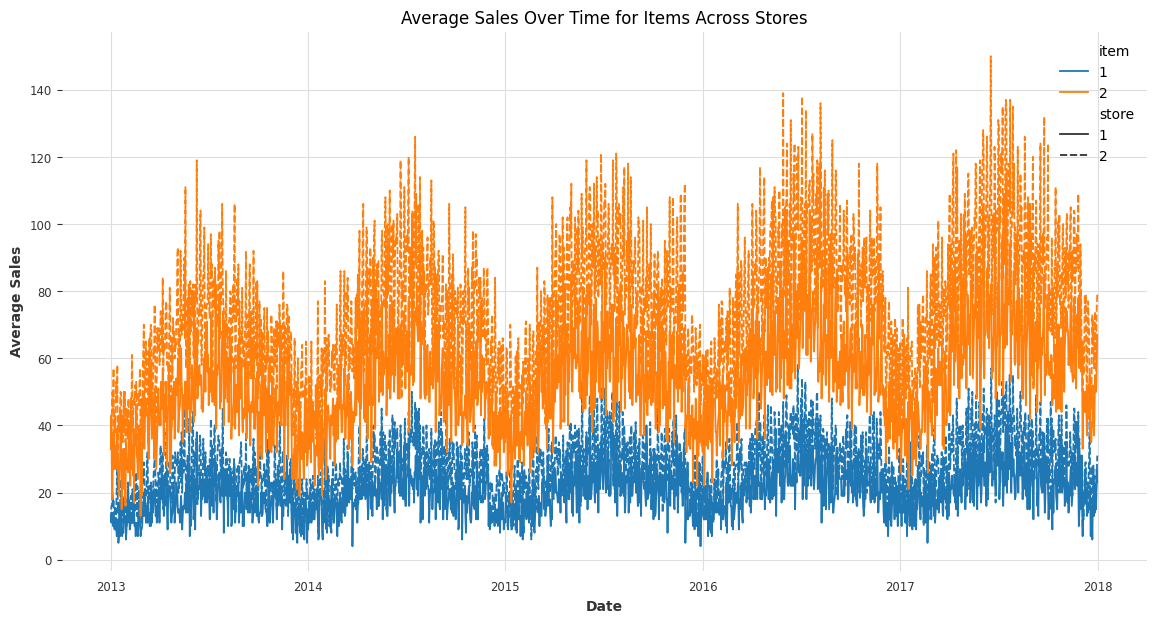

In [ ]:
# Using the function
stores_to_plot = [1, 2]
items_to_plot = [1, 2]
plot_item_sales_across_stores(df, stores_to_plot, items_to_plot)

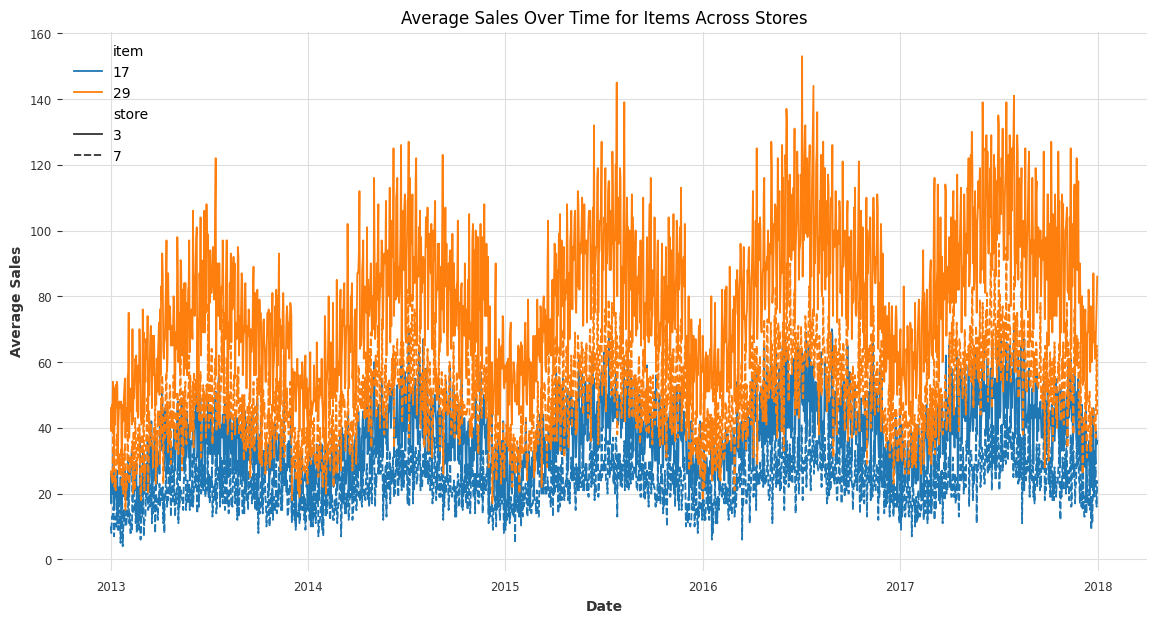

In [ ]:
# Using the function
stores_to_plot = [3, 7]
items_to_plot = [17, 29]
plot_item_sales_across_stores(df, stores_to_plot, items_to_plot)

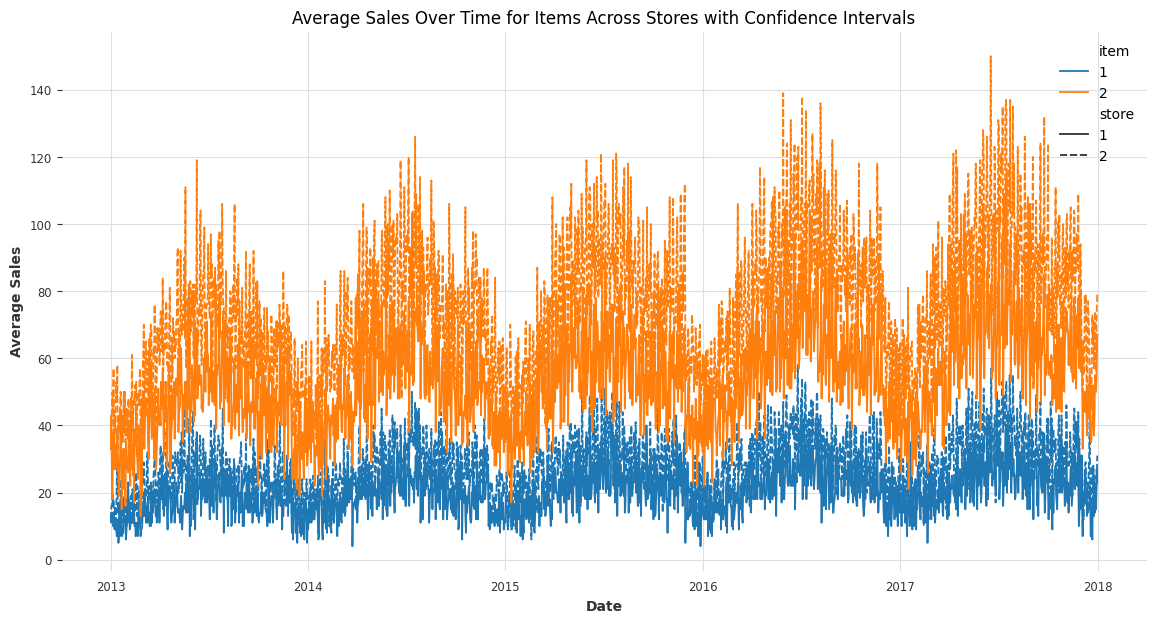

In [ ]:
# Plot average sales for multiple items across multiple stores with confidence intervals.

# Select multiple stores and items
stores_to_plot = [1, 2]
items_to_plot = [1, 2]

# Prepare data
item_store_sales = df[df['store'].isin(stores_to_plot) & df['item'].isin(items_to_plot)]
item_store_sales_grouped = item_store_sales.groupby(['store', 'item', item_store_sales.index]).agg({'sales': ['mean', 'std']})
item_store_sales_grouped.columns = ['mean_sales', 'std_sales']
item_store_sales_grouped.reset_index(inplace=True)

# Visualization
plt.figure(figsize=(14, 7))
sns.lineplot(data=item_store_sales_grouped, x='date', y='mean_sales', hue='item', style='store', errorbar='sd', palette='tab10')
plt.title('Average Sales Over Time for Items Across Stores with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()


We observe the following trends:

- Sales significantly decrease at the beginning and end of the year.
- The highest sales occur in the middle of the year (summer).
- There is clear seasonality for all stores and all items.

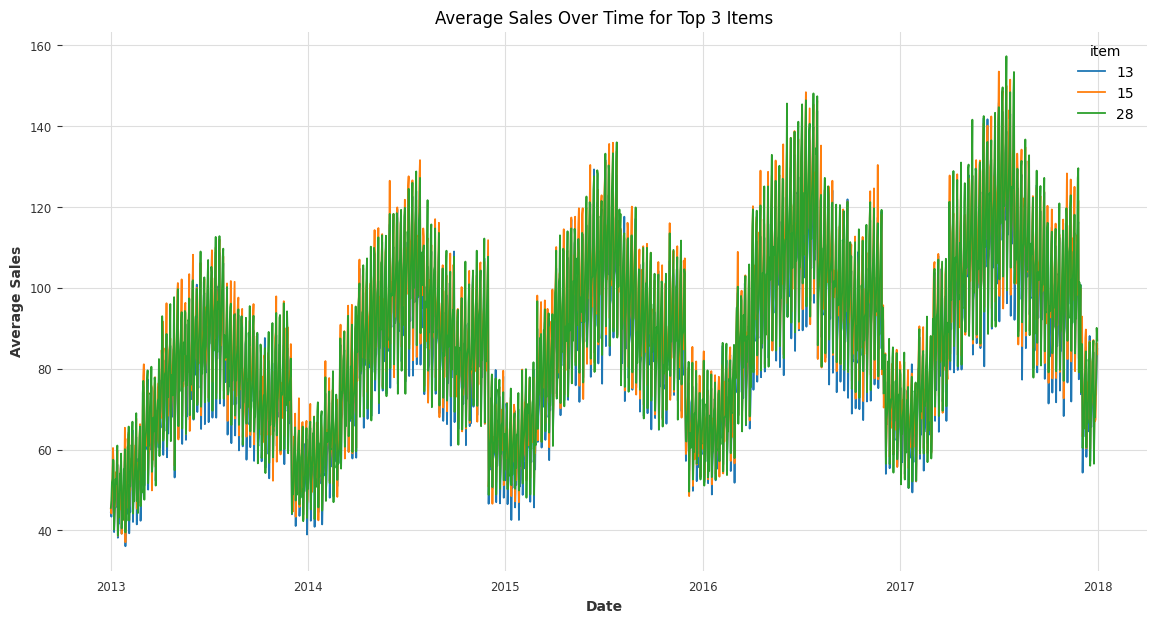

In [ ]:
# Identifying the top 3 items by total sales volume
top_items = df.groupby('item')['sales'].sum().sort_values(ascending=False).head(3).index

# Selecting data for the top 3 items
item_sales = df[df['item'].isin(top_items)]

# Preparing data
item_sales_grouped = item_sales.groupby(['item', item_sales.index]).agg({'sales': 'mean'})
item_sales_grouped.reset_index(inplace=True)

# Visualization
plt.figure(figsize=(14, 7))
sns.lineplot(data=item_sales_grouped, x='date', y='sales', hue='item', palette='tab10')
plt.title('Average Sales Over Time for Top 3 Items')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()


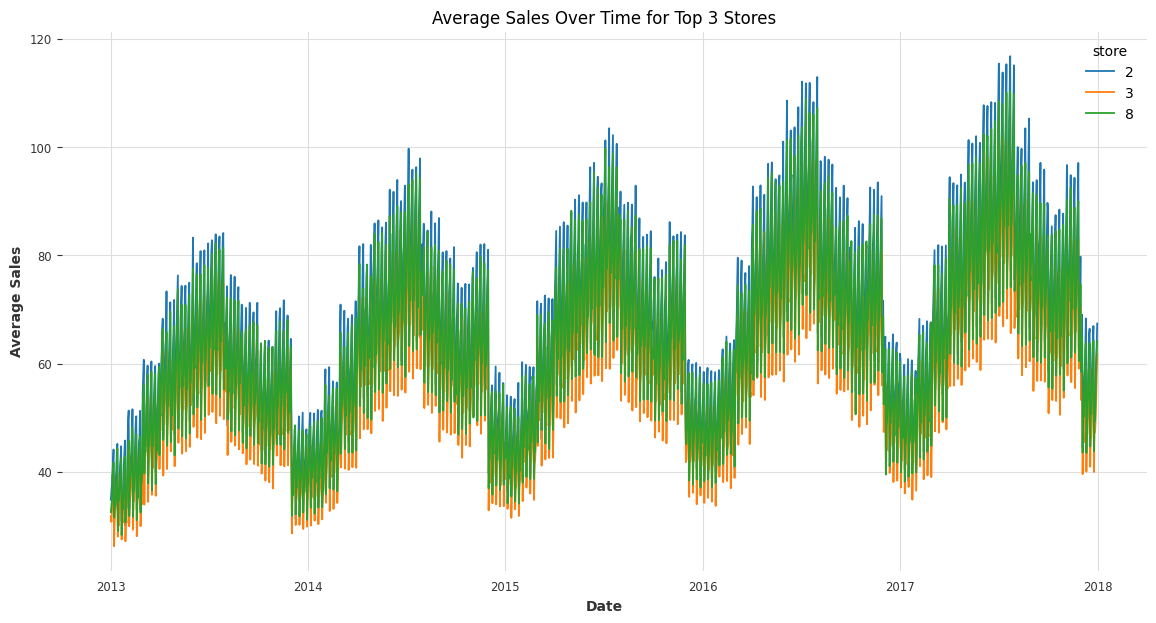

In [ ]:
# Identifying the top 3 stores by total sales volume
top_stores = df.groupby('store')['sales'].sum().sort_values(ascending=False).head(3).index

# Selecting data for the top 3 stores
store_sales = df[df['store'].isin(top_stores)]

# Preparing data
store_sales_grouped = store_sales.groupby(['store', store_sales.index]).agg({'sales': 'mean'})
store_sales_grouped.reset_index(inplace=True)

# Visualization
plt.figure(figsize=(14, 7))
sns.lineplot(data=store_sales_grouped, x='date', y='sales', hue='store', palette='tab10')
plt.title('Average Sales Over Time for Top 3 Stores')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

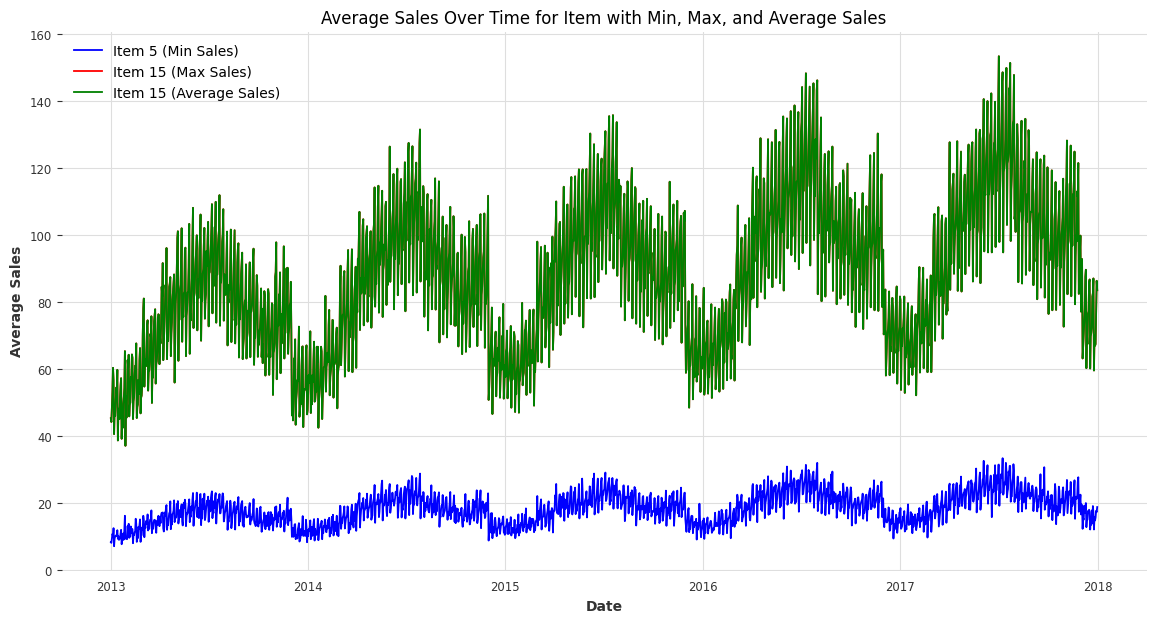

In [ ]:
# Identifying the item with minimum and maximum sales
min_sales_item = df.groupby('item')['sales'].sum().idxmin()
max_sales_item = df.groupby('item')['sales'].sum().idxmax()

# Identifying the item with average sales
mean_sales_item = df.groupby('item')['sales'].sum().idxmax()  # Initialized with the maximum item for further comparison

# Selecting data for items with minimum, maximum, and average sales
min_sales_item_data = df[df['item'] == min_sales_item]
max_sales_item_data = df[df['item'] == max_sales_item]
mean_sales_item_data = df[df['item'] == mean_sales_item]

# Calculating average sales per day
min_sales_item_grouped = min_sales_item_data.groupby(min_sales_item_data.index).agg({'sales': 'mean'})
max_sales_item_grouped = max_sales_item_data.groupby(max_sales_item_data.index).agg({'sales': 'mean'})
mean_sales_item_grouped = mean_sales_item_data.groupby(mean_sales_item_data.index).agg({'sales': 'mean'})

# Visualization
plt.figure(figsize=(14, 7))

plt.plot(min_sales_item_grouped.index, min_sales_item_grouped['sales'], label=f'Item {min_sales_item} (Min Sales)', color='blue')
plt.plot(max_sales_item_grouped.index, max_sales_item_grouped['sales'], label=f'Item {max_sales_item} (Max Sales)', color='red')
plt.plot(mean_sales_item_grouped.index, mean_sales_item_grouped['sales'], label=f'Item {mean_sales_item} (Average Sales)', color='green')

plt.title('Average Sales Over Time for Item with Min, Max, and Average Sales')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.show()

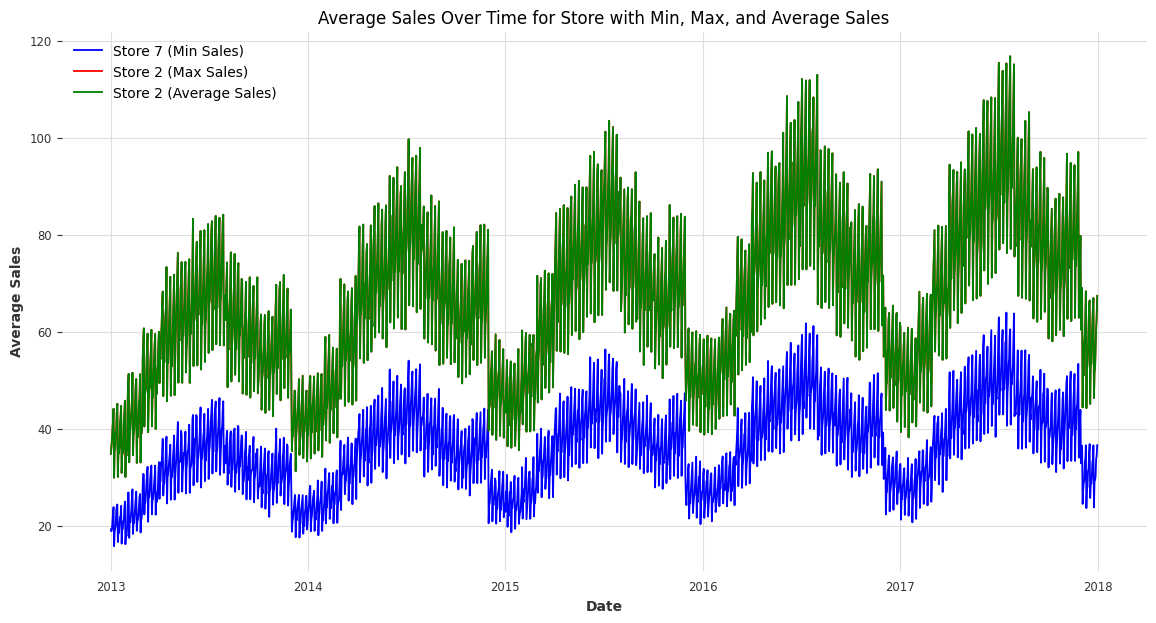

In [ ]:
# Identifying the store with minimum and maximum sales
min_sales_store = df.groupby('store')['sales'].sum().idxmin()
max_sales_store = df.groupby('store')['sales'].sum().idxmax()

# Identifying the store with average sales
mean_sales_store = df.groupby('store')['sales'].sum().idxmax()  # Initialized with the maximum store for further comparison

# Selecting data for stores with minimum, maximum, and average sales
min_sales_store_data = df[df['store'] == min_sales_store]
max_sales_store_data = df[df['store'] == max_sales_store]
mean_sales_store_data = df[df['store'] == mean_sales_store]

# Calculating average sales per day
min_sales_store_grouped = min_sales_store_data.groupby(min_sales_store_data.index).agg({'sales': 'mean'})
max_sales_store_grouped = max_sales_store_data.groupby(max_sales_store_data.index).agg({'sales': 'mean'})
mean_sales_store_grouped = mean_sales_store_data.groupby(mean_sales_store_data.index).agg({'sales': 'mean'})

# Visualization
plt.figure(figsize=(14, 7))

plt.plot(min_sales_store_grouped.index, min_sales_store_grouped['sales'], label=f'Store {min_sales_store} (Min Sales)', color='blue')
plt.plot(max_sales_store_grouped.index, max_sales_store_grouped['sales'], label=f'Store {max_sales_store} (Max Sales)', color='red')
plt.plot(mean_sales_store_grouped.index, mean_sales_store_grouped['sales'], label=f'Store {mean_sales_store} (Average Sales)', color='green')

plt.title('Average Sales Over Time for Store with Min, Max, and Average Sales')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.show()

# Visualization of 1 product from 1 store

**First**, I will analyze just one time series, and later I can loop the model training.

I will select a subset of data corresponding to the sales of item == 1 in store == 1.

**Then**, I will perform a decomposition of this time series using an additive model into trend, seasonality, and residuals using the statsmodels library.

**Finally**, I will draw conclusions from the obtained visualizations.

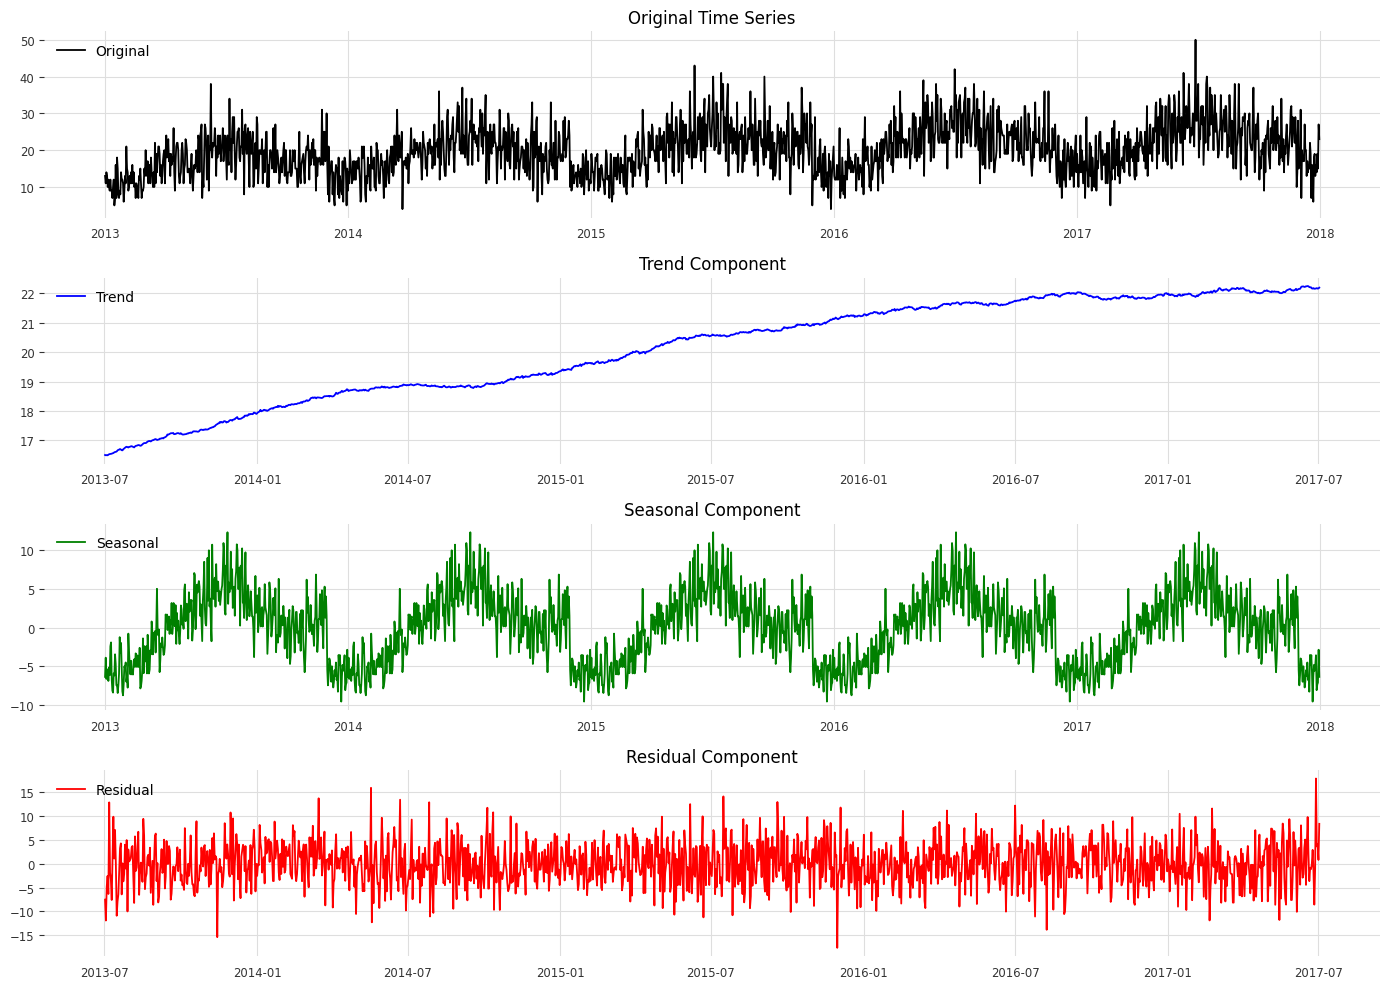

In [ ]:
# Data Filtering
item_id = 1
store_id = 1
filtered_data = df[(df['item'] == item_id) & (df['store'] == store_id)].copy()

# Ensure the data is sorted by date
filtered_data = filtered_data.sort_index()

# Decomposition
result = seasonal_decompose(filtered_data['sales'], model='additive', period=365)

# Visualization of results
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(filtered_data.index, filtered_data['sales'], label='Original', color='black')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

The trend is upward. Seasonality repeats annually. The balance is large.

# TimeSeries for sales

From the previously filtered data subset, an object of the TimeSeries class in darts can be created using only the sales column.

In [ ]:
# Check that the index has the correct type
filtered_data.index = pd.to_datetime(filtered_data.index)

# Create a TimeSeries object for the 'sales' column
time_series = TimeSeries.from_dataframe(filtered_data, value_cols='sales')

# Check the created object
time_series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


To split the data into training and validation sets, ensuring that the validation starts from October 1, 2017, you can use the series.split_before method. After splitting, visualize both the training and validation parts on a single plot, similar to the example shown in the lecture.

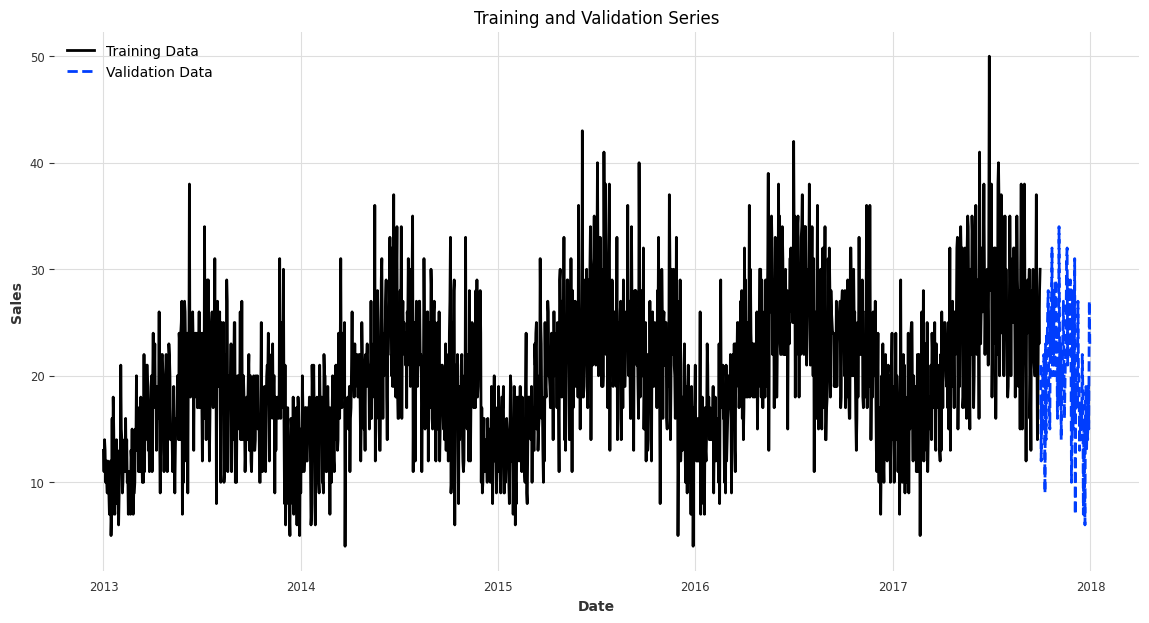

In [ ]:
# Creating a TimeSeries object for the 'sales' column
time_series = TimeSeries.from_dataframe(filtered_data, time_col=None, value_cols='sales')

# Splitting the data into training and validation sets
train_series, val_series = time_series.split_before(pd.Timestamp('2017-10-01'))

# Visualization
plt.figure(figsize=(14, 7))
train_series.plot(label='Training Data')
val_series.plot(label='Validation Data', linestyle='--')
plt.title('Training and Validation Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Lags, seasonality

To analyze autocorrelation in the time series, one should construct a partial autocorrelation function. This will help determine which lags may be important for forecasting.

<Figure size 4000x2000 with 0 Axes>

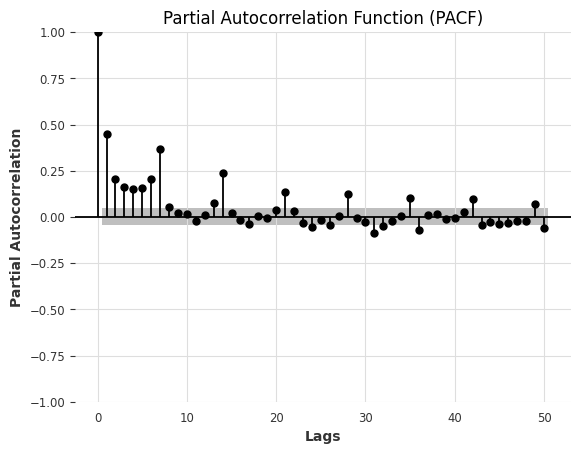

In [ ]:
# Getting the series data
sales_series = time_series.pd_series()

# Building the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(40, 20))
plot_pacf(sales_series, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

Important lags are those in the range 1 to 7, and every 7th lag is also important. Another 31 and 36, but it seems more like a coincidence than a pattern.

Identify the presence of seasonality in the training series by using the check_seasonality function from the darts library.

In [ ]:
# Check for seasonality
seasonality = check_seasonality(time_series)

# Output of seasonality check results
seasonality

(True, 7)

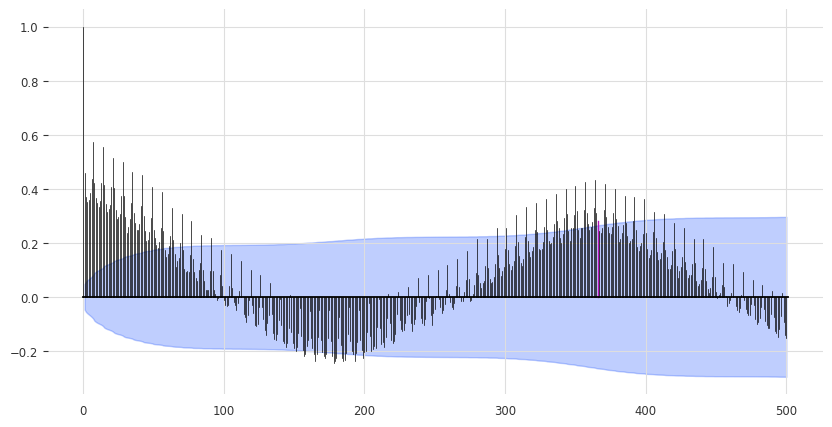

In [ ]:
plot_acf(train_series, m=366, alpha=0.05, max_lag=500)

In [ ]:
for m in range(2, m):
    is_seasonal, period = check_seasonality(train_series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


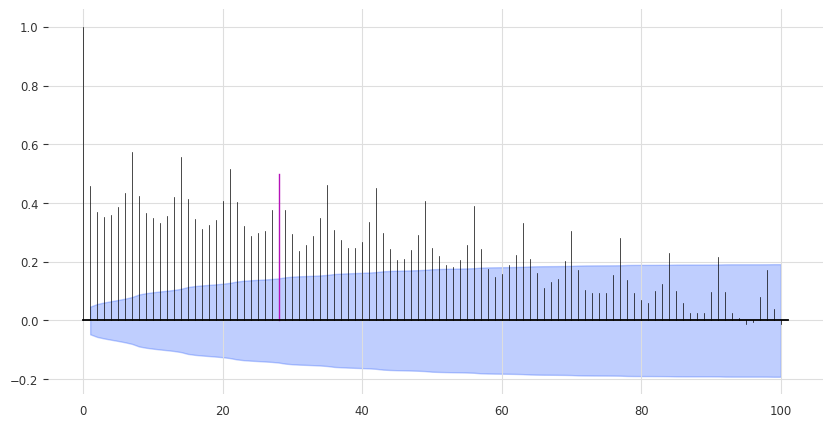

In [ ]:
plot_acf(train_series, m=28, alpha=0.05, max_lag=100)

# Training models

I plan to build a naive model using NaiveSeasonal and NaiveDrift for forecasting the data. I will determine the number of steps for forecasting based on the analysis conducted in previous sections. After that, I will visualize the predictions against the actual data to assess the quality of the forecasts. Finally, I will conclude on the accuracy of the model.

In [ ]:
# Defining the number of steps for forecasting
forecast_steps = len(val_series)

# Creating models
naive_seasonal = NaiveSeasonal()
naive_drift = NaiveDrift()

# Training models
naive_seasonal.fit(train_series)
naive_drift.fit(train_series)

# Forecasting
forecast_naive_seasonal = naive_seasonal.predict(n=forecast_steps)
forecast_naive_drift = naive_drift.predict(n=forecast_steps)

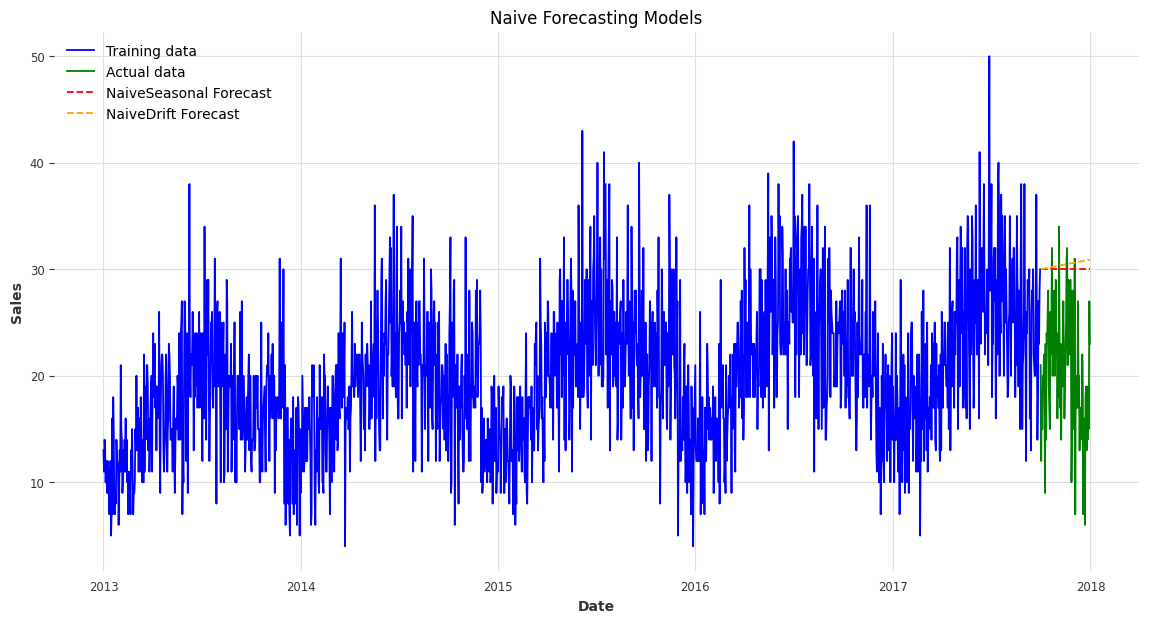

In [ ]:
plt.figure(figsize=(14, 7))

# Visualizing actual data
plt.plot(train_series.time_index, train_series.values(), label='Training data', color='blue')
plt.plot(val_series.time_index, val_series.values(), label='Actual data', color='green')

# Visualizing forecasts for NaiveSeasonal
plt.plot(forecast_naive_seasonal.time_index, forecast_naive_seasonal.values(), label='NaiveSeasonal Forecast', color='red', linestyle='--')

# Visualizing forecasts for NaiveDrift
plt.plot(forecast_naive_drift.time_index, forecast_naive_drift.values(), label='NaiveDrift Forecast', color='orange', linestyle='--')

plt.title('Naive Forecasting Models')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='date'>

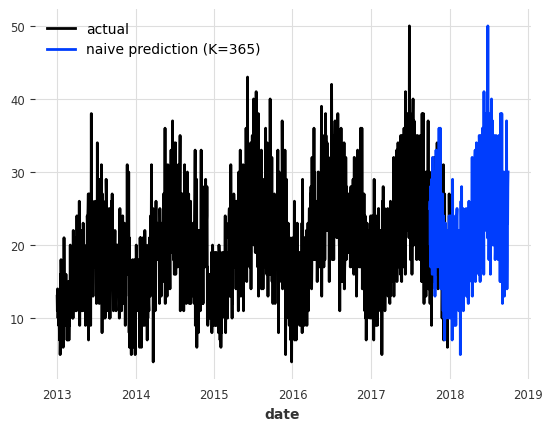

In [ ]:
# Create a NaiveSeasonal model with a seasonal period of 365
seasonal_model = NaiveSeasonal(K=365)

# Fit the model to the training series
seasonal_model.fit(train_series)

# Generate a forecast for the next 365 steps
seasonal_forecast = seasonal_model.predict(365)

# Plot the actual time series data
time_series.plot(label="actual")

# Plot the naive prediction generated by the seasonal model
seasonal_forecast.plot(label="naive prediction (K=365)")


The model is not accurate and cannot be used for forecasting.

I will calculate the forecast error on the validation set using the naive model with MAPE. Then, I will compute the forecast error on the validation set for all models.

In [ ]:
# Calculation of MAPE for NaiveSeasonal forecasts
mape_naive_seasonal = mape(val_series, forecast_naive_seasonal)
print(f"MAPE for NaiveSeasonal: {mape_naive_seasonal:.2f}%")

# Calculation of MAPE for NaiveDrift forecasts
mape_naive_drift = mape(val_series, forecast_naive_drift)
print(f"MAPE for NaiveDrift: {mape_naive_drift:.2f}%")

MAPE for NaiveSeasonal: 66.23%
MAPE for NaiveDrift: 68.74%


I will train the XGBModel from Darts to forecast our data. I can include any additional features that I find necessary, such as date-related features. I will then conclude on the model's performance.

In [ ]:
# Restore the date as a column
def reset_index(df):
    df = df.copy()
    df['date'] = df.index
    df.set_index('date', inplace=True)
    return df

# Preparation of signs from the date
def create_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    return df

# Restoring the date as a column and creating attributes
train_df = reset_index(train_series.pd_dataframe())
train_df = create_features(train_df)
val_df = reset_index(val_series.pd_dataframe())
val_df = create_features(val_df)

# Create features for XGBoost
X_train = train_df[['year', 'month', 'day', 'day_of_week']]
y_train = train_df['sales']
X_val = val_df[['year', 'month', 'day', 'day_of_week']]
y_val = val_df['sales']


In [ ]:
# Building and training an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, max_depth=10)
xgb_model.fit(X_train, y_train)

# Forecast
forecast_xgb = xgb_model.predict(X_val)

MAPE for XGBoost: 0.31%


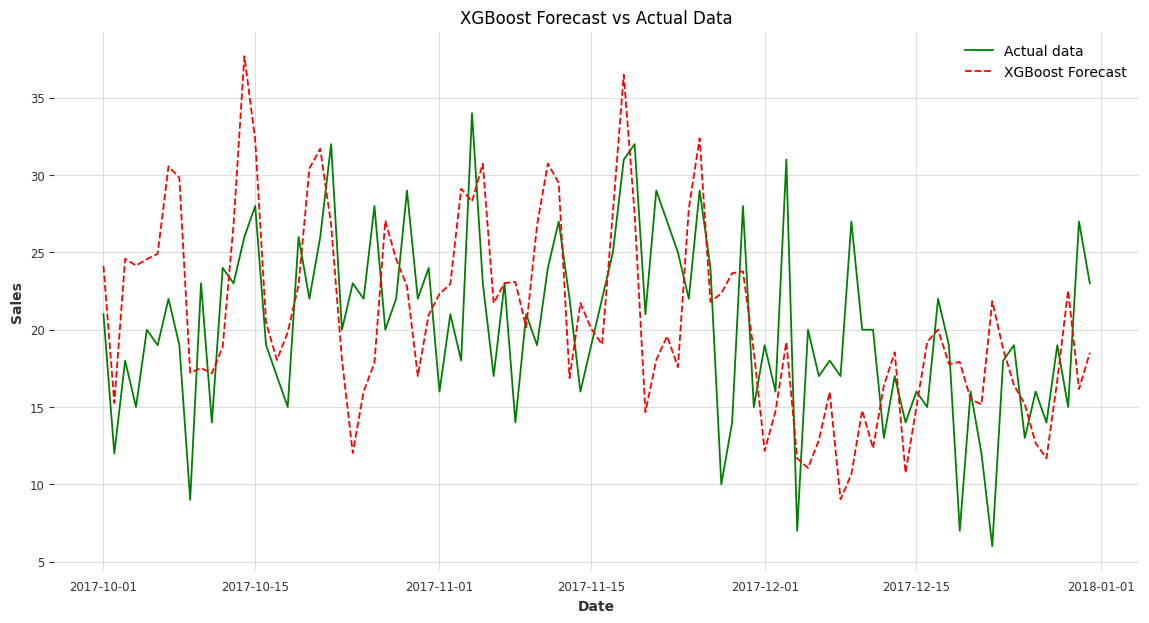

In [ ]:
# Calculation of MAPE for XGBoost
mape_xgb = mean_absolute_percentage_error(y_val, forecast_xgb)
print(f"MAPE for XGBoost: {mape_xgb:.2f}%")

# Visualization of forecasts
plt.figure(figsize=(14, 7))

# Visualization of real data
plt.plot(val_series.time_index, y_val, label='Actual data', color='green')

# Visualization of predictions for XGBoost
plt.plot(val_series.time_index, forecast_xgb, label='XGBoost Forecast', color='red', linestyle='--')

plt.title('XGBoost Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

The model showed a very good result. Can be used for forecasting. But according to the condition of the problem, we needed to use XGBModel from the darts library

In [ ]:
def eval_forecast(model, val_series, forecast):
    # Calculate the Mean Absolute Percentage Error (MAPE) for the forecast
    mape_ = mape(val_series, forecast)
    # Print the MAPE result for the given model
    print(f"model {model} obtains MAPE: {mape_:.2f}%")
    return mape_

def fit_eval_model(model):
    # Fit the model on the training series
    model.fit(train_series)
    # Predict the forecast for the length of the validation series
    forecast = model.predict(len(val_series))
    # Evaluate the forecast using the validation series
    eval_forecast(model, val_series, forecast)

# Evaluate and fit the specified models
fit_eval_model(ExponentialSmoothing())
fit_eval_model(AutoARIMA())
fit_eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 39.01%
model AutoARIMA() obtains MAPE: 37.90%
model Theta() obtains MAPE: 36.87%


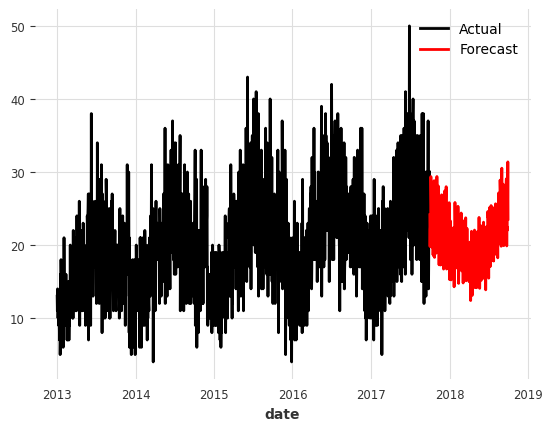

In [ ]:
# Creating TimeSeries for training and validation data
train_series = TimeSeries.from_dataframe(X_train.join(y_train), value_cols='sales')  # 'sales' is the target variable
val_series = TimeSeries.from_dataframe(X_val.join(y_val), value_cols='sales')

# Scaling the data
scaler = Scaler()
train_series_scaled = scaler.fit_transform(train_series)
val_series_scaled = scaler.transform(val_series)

# Building the XGBoost model
model = XGBModel(
    lags=7,  # Weekly lags
    output_chunk_length=365,  # Forecast for 365 days
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)

# Training the model
model.fit(train_series_scaled)

# Forecast
forecast = model.predict(n=365)

# Inverse scaling
forecast = scaler.inverse_transform(forecast)

# Displaying the results
train_series.plot(label="Actual")
forecast.plot(label="Forecast", color="red")
plt.legend()
plt.show()

In [ ]:
# Evaluate the forecast using the validation series and the scaled forecast
eval_forecast(model, val_series_scaled, forecast);

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 7934.81%


In [ ]:
# Build the XGBoost model with different hyperparameters
model = XGBModel(
    lags=52,  # Using weekly lags (52 weeks for annual forecasting)
    output_chunk_length=7,  # Forecast for one week ahead
    n_estimators=500,  # Increased number of trees
    max_depth=3,  # Decreased depth of trees
    learning_rate=0.01,  # Decreased learning rate
    subsample=0.7,  # Slightly reduced fraction of data for random sampling for each tree
    colsample_bytree=0.7  # Reduced fraction of features used for each tree
)

# Train the model
model.fit(train_series_scaled)

# Forecast
forecast = model.predict(len(val_series_scaled))

# Evaluate the result
eval_forecast(model, val_series_scaled, forecast)

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 48.37%


48.374088582806095

Ideas for Further Improvement:

- The performance of the XGBModel from the darts library is not satisfactory.
- It would be beneficial to manually tune the hyperparameters and implement automated tuning methods, such as GridSearchCV.
- There are already better models available without additional tuning.
- Therefore, we will focus on utilizing these more effective models.

I will train the ExponentialSmoothing model and evaluate its performance, providing a conclusion regarding its quality.

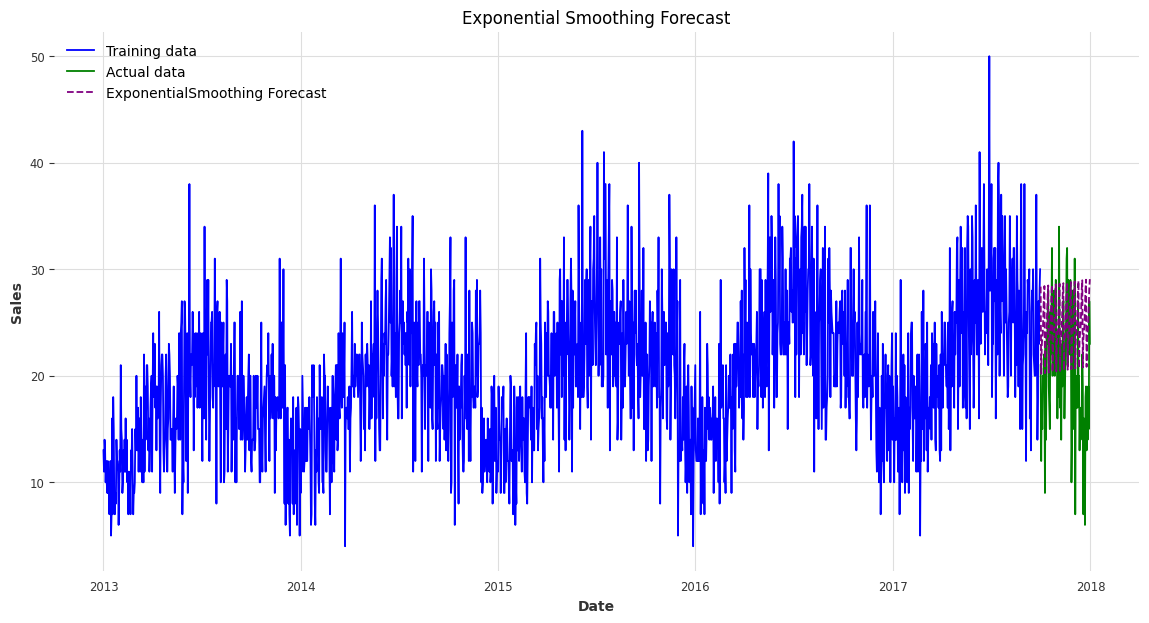

MAPE for ExponentialSmoothing: 39.01%


In [ ]:
# Setting up the ExponentialSmoothing model without parameters
model_exp_smooth = ExponentialSmoothing()

# Training the model on the training data
model_exp_smooth.fit(train_series)

# Forecasting
forecast_exp_smooth = model_exp_smooth.predict(n=len(val_series))

# Visualizing the results
plt.figure(figsize=(14, 7))
plt.plot(train_series.time_index, train_series.values(), label='Training data', color='blue')
plt.plot(val_series.time_index, val_series.values(), label='Actual data', color='green')
plt.plot(forecast_exp_smooth.time_index, forecast_exp_smooth.values(), label='ExponentialSmoothing Forecast', color='purple', linestyle='--')

plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Evaluating the forecast quality
mape_exp_smooth = mape(val_series, forecast_exp_smooth)
print(f'MAPE for ExponentialSmoothing: {mape_exp_smooth:.2f}%')

The quality of the model is better than the naive one, but in general one needs to find and train more accurate models, or significantly improve it by finding parameters or hyperparameters.

I'm planning to do the following: Train an ARIMA model and choose the parameters.

In [ ]:
# Preparing data for pmdarima
train_df = train_series.pd_dataframe()
val_df = val_series.pd_dataframe()

# Training the ARIMA model with automatic parameter selection
model_arima = auto_arima(train_df['sales'], seasonal=True, m=7, stepwise=True, trace=True)

# Forecasting
forecast_arima, conf_int = model_arima.predict(n=len(val_df), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=12.47 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11699.312, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11207.039, Time=0.93 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10659.514, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11697.315, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10763.373, Time=0.44 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=9.59 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10587.183, Time=5.42 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=13.56 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=11549.258, Time=1.58 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10580.615, Time=3.08 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10652.927, Time=1.55 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=14.24 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=10.12 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=111

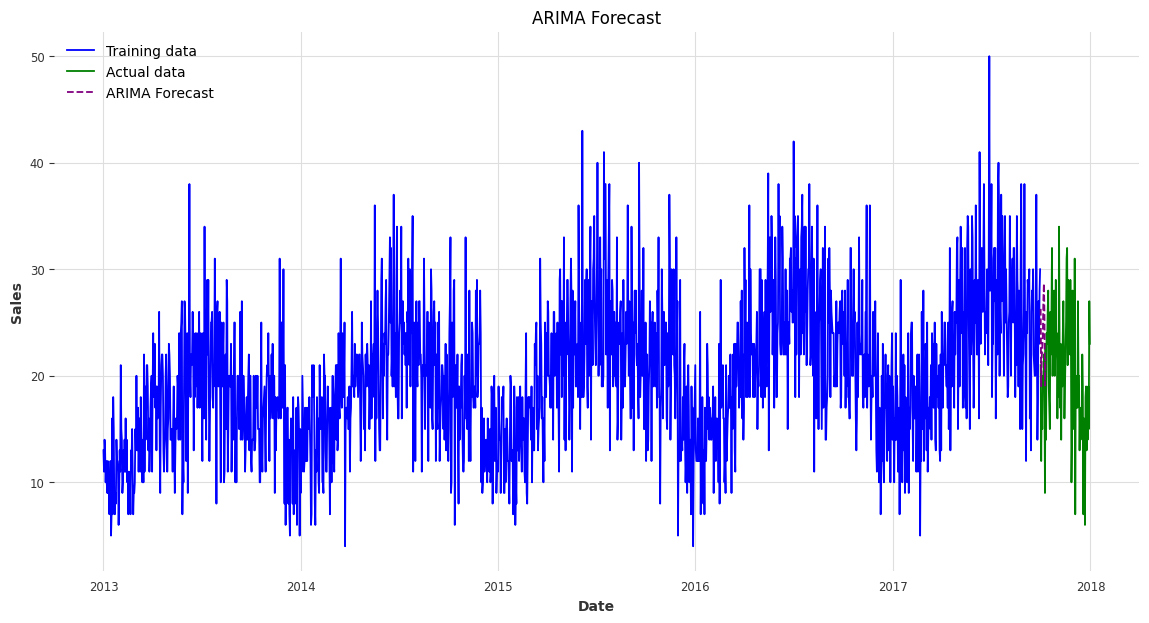

MAPE for ARIMA: 40.13%


In [ ]:
# Converting the forecast to TimeSeries
forecast_arima_series = TimeSeries.from_times_and_values(val_series.time_index[:len(forecast_arima)], forecast_arima)

# Visualizing the results
plt.figure(figsize=(14, 7))
plt.plot(train_series.time_index, train_series.values(), label='Training data', color='blue')
plt.plot(val_series.time_index, val_series.values(), label='Actual data', color='green')
plt.plot(val_series.time_index[:len(forecast_arima)], forecast_arima_series.values(), label='ARIMA Forecast', color='purple', linestyle='--')

plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Evaluating the forecast quality
mape_arima = mape(val_series, forecast_arima_series)
print(f'MAPE for ARIMA: {mape_arima:.2f}%')

The quality of the model is poor, we are looking for further options.

I will look for the optimal parameters for the ARIMA model using the AutoARIMA model. I will perform the parameter search, report which parameters were found to be optimal, and evaluate the model's quality. I will also determine whether the quality has improved compared to the previous experiment.

In [ ]:
# Training the ARIMA model with automatic parameter selection
model_arima_auto = auto_arima(train_df['sales'], seasonal=True, m=7, stepwise=True, trace=True)

# Outputting the optimal parameters of the model
print("Optimal ARIMA parameters:")
print(model_arima_auto.summary())

# Forecasting
forecast_arima_auto, conf_int = model_arima_auto.predict(n=len(val_df), return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=11.97 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11699.312, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11207.039, Time=1.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10659.514, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11697.315, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10763.373, Time=0.47 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.55 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10587.183, Time=3.02 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=12.63 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=11549.258, Time=1.62 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10580.615, Time=6.01 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10652.927, Time=1.69 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=13.12 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.21 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1118

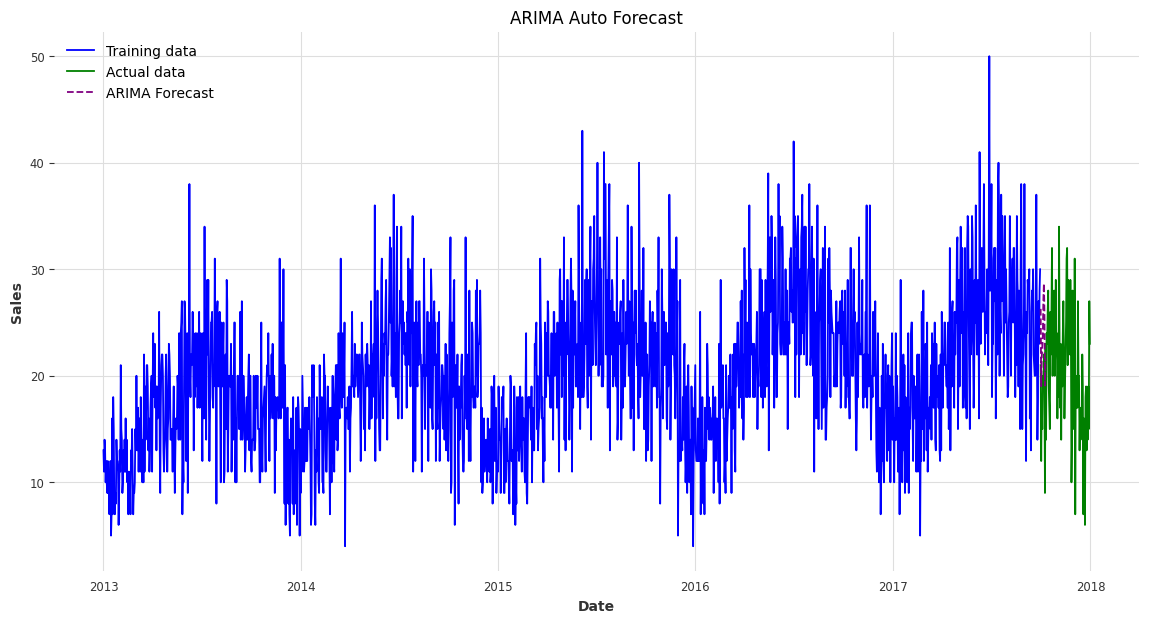

MAPE for ARIMA Auto: 40.13%
MAPE for previous ARIMA model: 40.13%


In [ ]:
# Converting the forecast to TimeSeries
forecast_arima_auto_series = TimeSeries.from_times_and_values(val_series.time_index[:len(forecast_arima_auto)], forecast_arima_auto)

# Visualizing the results
plt.figure(figsize=(14, 7))
plt.plot(train_series.time_index, train_series.values(), label='Training data', color='blue')
plt.plot(val_series.time_index, val_series.values(), label='Actual data', color='green')
plt.plot(val_series.time_index[:len(forecast_arima_auto)], forecast_arima_auto_series.values(), label='ARIMA Forecast', color='purple', linestyle='--')

plt.title('ARIMA Auto Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Evaluating the quality of the forecast
mape_arima_auto = mape(val_series, forecast_arima_auto_series)
print(f'MAPE for ARIMA Auto: {mape_arima_auto:.2f}%')

# Evaluating the quality of the previous ARIMA model for comparison
print(f'MAPE for previous ARIMA model: {mape_arima:.2f}%')

The quality of the model has not improved. It is worth looking further. But since there were already better models than this one, I will experiment with them.

I'm planning to train a Prophet model and evaluate its quality.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl07qr8k4/eaum4q0j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl07qr8k4/kkqq4jtg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60458', 'data', 'file=/tmp/tmpl07qr8k4/eaum4q0j.json', 'init=/tmp/tmpl07qr8k4/kkqq4jtg.json', 'output', 'file=/tmp/tmpl07qr8k4/prophet_modelqt66qgfk/prophet_model-20240815100548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:05:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:05:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


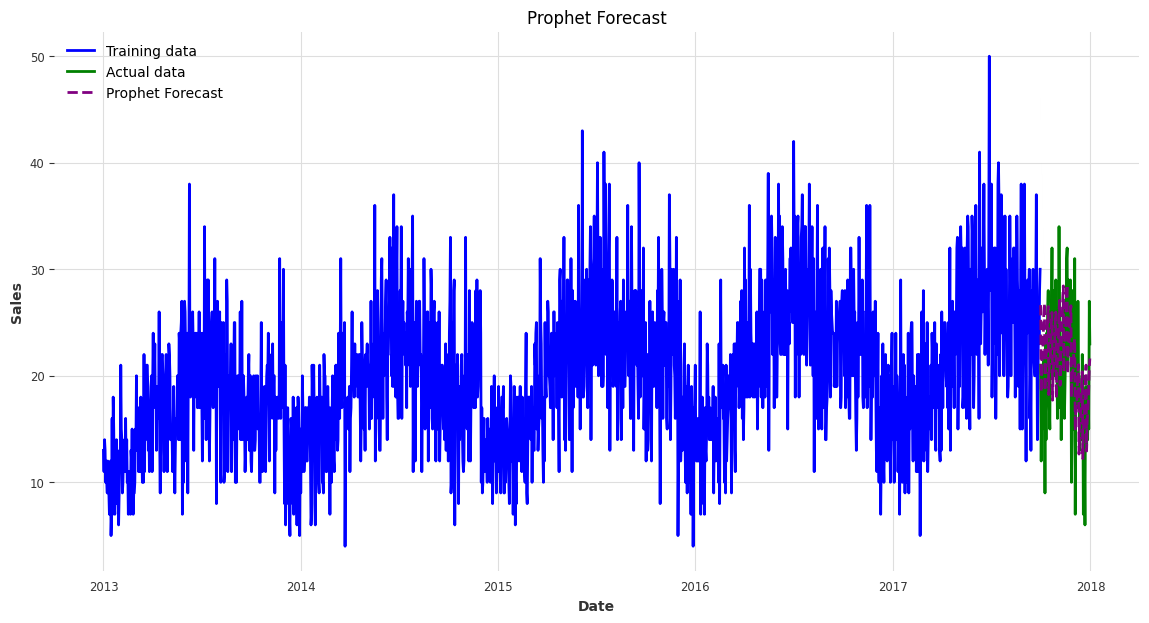

In [ ]:
# Converting DataFrame to TimeSeries
train_series = TimeSeries.from_dataframe(train_df, time_col='ds', value_cols='y')
val_series = TimeSeries.from_dataframe(val_df, time_col='ds', value_cols='y')

# Initializing and training the Prophet model
model = Prophet()
model.fit(train_series)

# Forecasting
forecast = model.predict(len(val_series))

# Visualization of results
plt.figure(figsize=(14, 7))
train_series.plot(label='Training data', color='blue')
val_series.plot(label='Actual data', color='green')
forecast.plot(label='Prophet Forecast', color='purple', linestyle='--')

plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from darts.metrics import mape
# Forecast quality assessment
mape_prophet = mape(val_series, forecast)
print(f'MAPE for Prophet: {mape_prophet:.2f}%')

MAPE for Prophet: 23.80%


So far, this model shows one of the best qualities. Can be used for forecasting.

I plan to train the RNNModel and evaluate its quality.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE for RNN: 30.50%


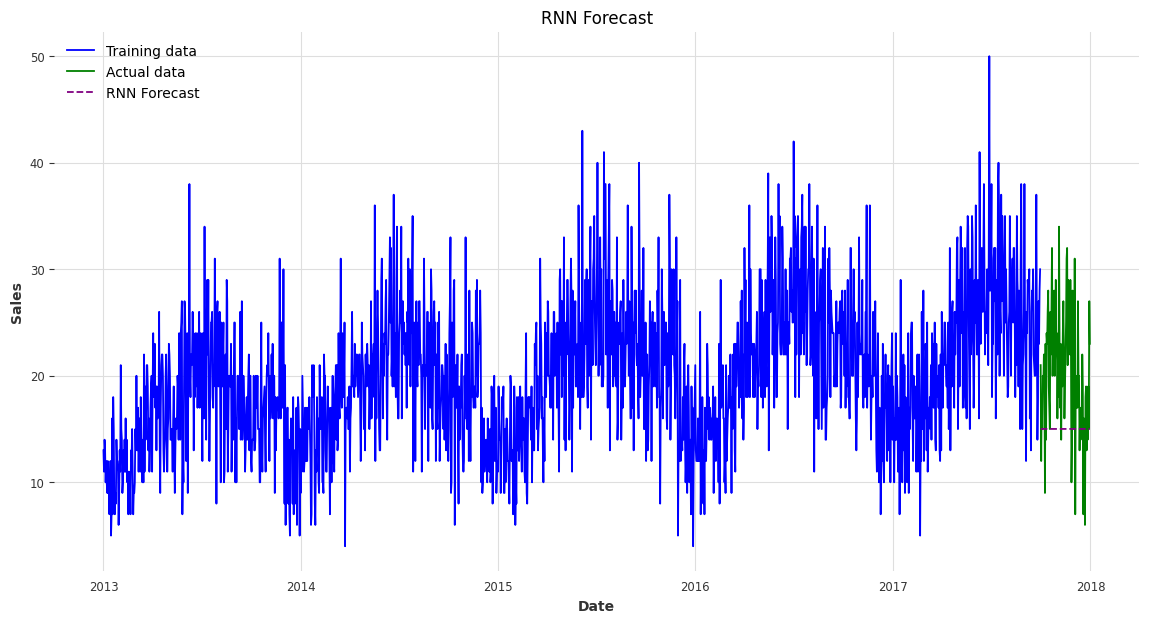

In [ ]:
# Building and training the LSTM model
model_rnn = RNNModel(model='LSTM', input_chunk_length=24, n_epochs=10)
model_rnn.fit(train_series)

# Forecasting
forecast_rnn = model_rnn.predict(n=len(val_series))

# Evaluating forecast quality
mape_rnn = mape(val_series, forecast_rnn)
print(f'MAPE for RNN: {mape_rnn:.2f}%')

# Visualizing results
plt.figure(figsize=(14, 7))
plt.plot(train_series.time_index, train_series.values(), label='Training data', color='blue')
plt.plot(val_series.time_index, val_series.values(), label='Actual data', color='green')
plt.plot(val_series.time_index, forecast_rnn.values(), label='RNN Forecast', color='purple', linestyle='--')

plt.title('RNN Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

The quality is worse than in the previous model, we will not use it. But overall better than most other pre-trained models.

I plan to perform a backtest for the best model I identified in my research over a one-year period, making predictions for one month at a time. I will visualize how the model behaved during the backtest and determine its accuracy.

  0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl07qr8k4/3pj_0ypt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl07qr8k4/wyc123ob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43970', 'data', 'file=/tmp/tmpl07qr8k4/3pj_0ypt.json', 'init=/tmp/tmpl07qr8k4/wyc123ob.json', 'output', 'file=/tmp/tmpl07qr8k4/prophet_modelbfrxk83o/prophet_model-20240815105548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:55:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:55:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  8%|▊         | 1/12 [00:00<00:09,  1.11it/s]INFO:prophet:Disabling daily seasonality. Run prophet with

MAPE for Prophet on Backtest: 21.97%


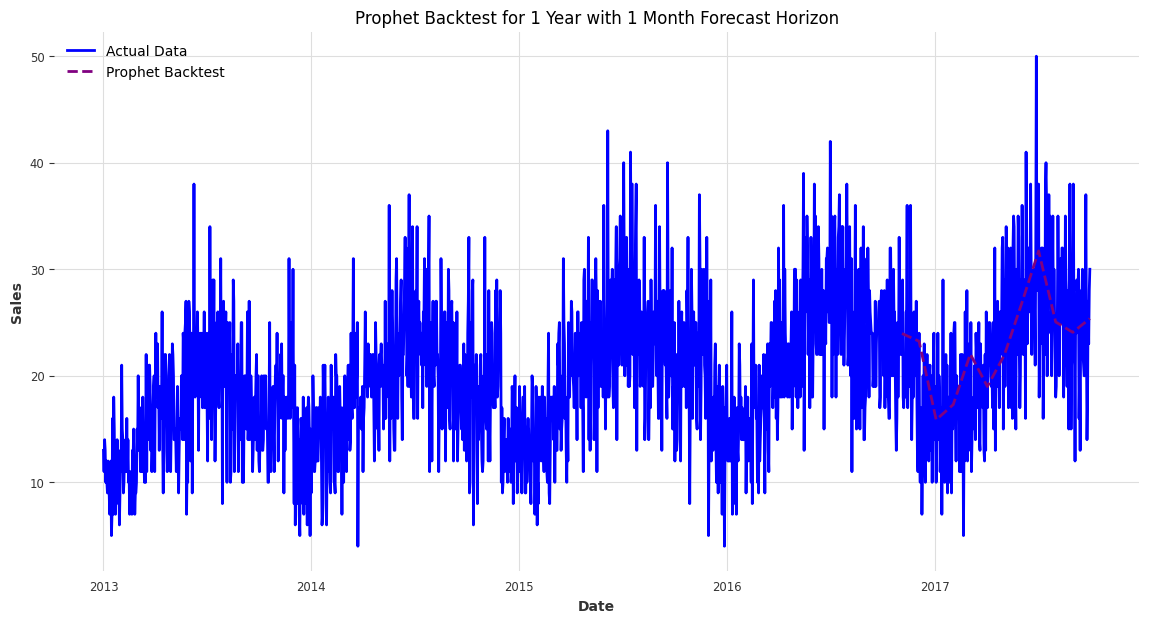

In [ ]:
# Converting DataFrame to TimeSeries
train_series = TimeSeries.from_dataframe(train_df, time_col='ds', value_cols='y')
val_series = TimeSeries.from_dataframe(val_df, time_col='ds', value_cols='y')

# Initializing the Prophet model
model_prophet = Prophet()

# Backtesting Prophet over 1 year with a 1-month forecast step
backtest_year = model_prophet.historical_forecasts(
    train_series,
    start=train_series.time_index[-12 * 30],  # one year ago
    forecast_horizon=30,  # forecast for 1 month
    stride=30,  # every month
    retrain=True,  # retraining the model at each step
    verbose=True
)

# Evaluating MAPE
mape_prophet = mape(train_series, backtest_year)
print(f"MAPE for Prophet on Backtest: {mape_prophet:.2f}%")

# Visualizing backtest results
plt.figure(figsize=(14, 7))
train_series.plot(label='Actual Data', color='blue')
backtest_year.plot(label='Prophet Backtest', color='purple', linestyle='--')
plt.title('Prophet Backtest for 1 Year with 1 Month Forecast Horizon')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

It became better by approximately 2%.

MAPE for XGBoost on Backtest: 0.29%


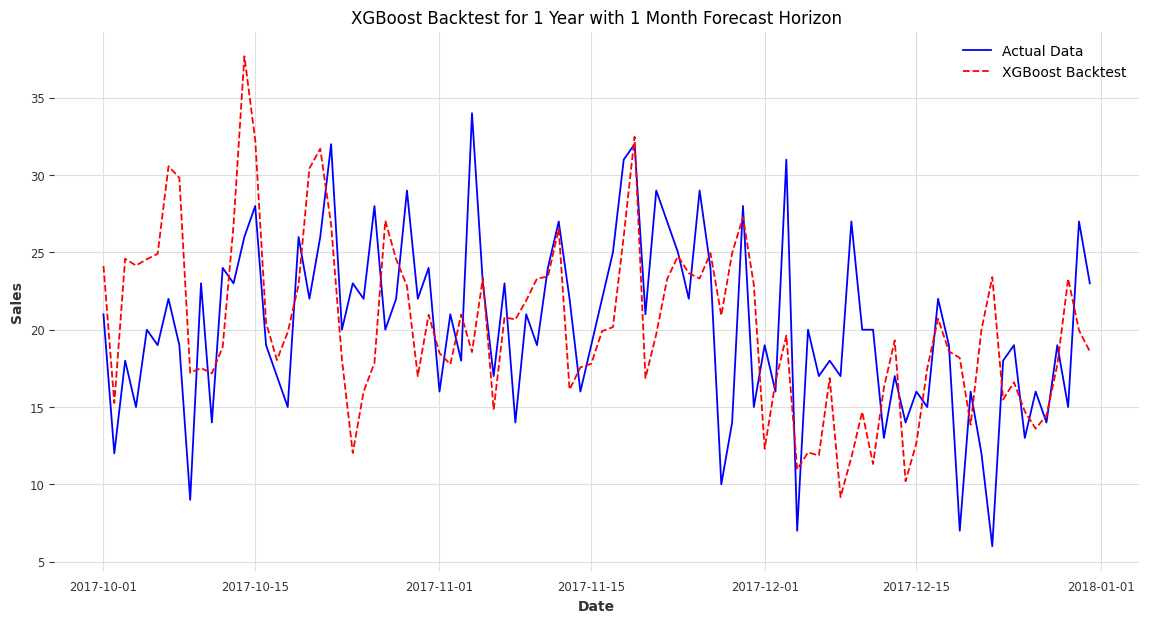

In [ ]:
# Restoring date as a column and preparing features
def reset_index(df):
    df = df.copy()
    df['date'] = df.index
    df.set_index('date', inplace=True)
    return df

# Creating features from the date
def create_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    return df

# Preparing data
train_df = reset_index(train_series.pd_dataframe())
train_df = create_features(train_df)
val_df = reset_index(val_series.pd_dataframe())
val_df = create_features(val_df)

# Creating features for XGBoost
X_train = train_df[['year', 'month', 'day', 'day_of_week']]
y_train = train_df['y']
X_val = val_df[['year', 'month', 'day', 'day_of_week']]
y_val = val_df['y']

# Initializing the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, max_depth=10)

# Backtesting XGBoost over 1 year with a 1-month forecast step
backtest_forecasts = []
backtest_actuals = []
stride = 30  # 1 month

for i in range(0, len(X_val), stride):
    # Training the model
    xgb_model.fit(X_train, y_train)

    # Forecasting for the next month
    forecast_xgb = xgb_model.predict(X_val[i:i+stride])

    # Storing forecasts and actual values
    backtest_forecasts.extend(forecast_xgb)
    backtest_actuals.extend(y_val[i:i+stride].values)

    # Adding new data to the training set
    X_train = pd.concat([X_train, X_val[i:i+stride]])
    y_train = np.concatenate([y_train, y_val[i:i+stride]])

# Calculating MAPE
mape_xgb = mean_absolute_percentage_error(backtest_actuals, backtest_forecasts)
print(f"MAPE for XGBoost on Backtest: {mape_xgb:.2f}%")

# Visualizing backtest results
plt.figure(figsize=(14, 7))
plt.plot(val_series.time_index[:len(backtest_actuals)], backtest_actuals, label='Actual Data', color='blue')
plt.plot(val_series.time_index[:len(backtest_forecasts)], backtest_forecasts, label='XGBoost Backtest', color='red', linestyle='--')
plt.title('XGBoost Backtest for 1 Year with 1 Month Forecast Horizon')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

We haven't figured out all the options, but it looks good!

I would use the model that showed the best results, which in our case is XGBoost from the standard library. But according to the condition of the task, we use the darts library and the best Prophet model.

According to the general process, there is absolutely no point in re-determining the results of all models, as we historically see that the data are similar and probably will not change radically in 1 month. Therefore, we can take Prophet for the next forecasts.